In [17]:
# Import every package we need

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [18]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize, robust_optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import prim, dimensional_stacking, cart
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [20]:
from visualization_functions import histogram_maker, mean_outcomes, aggregate_outcomes, scatter_maker, pairplot_maker, boxplot_histogram_maker

In [21]:
import pickle

results_MORO, convergence = pickle.load(open('Outcomes/MORO_s50_nfe20000.pkl', 'rb'))

In [23]:
results_MORO

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score
0,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.861056e-06,1.196531e+18,1.178112e+16,3.252648e+08
1,1,1,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.133849e+11,1.143893e-07,1.196531e+18,9.305655e+18,0.000000e+00
2,0,0,1,0,0,0,1,1,1,0,...,3,2,2,1,1,7.853715e+11,9.160793e-08,1.196531e+18,6.272040e+18,1.574746e+06
3,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.292400e-04,1.196531e+18,1.178112e+16,0.000000e+00
4,0,0,0,0,0,0,0,1,1,0,...,3,2,2,1,1,1.980599e+14,1.307336e-04,1.196531e+18,7.906444e+17,0.000000e+00
5,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,4.577942e+14,3.845736e-04,1.501146e+18,0.000000e+00,0.000000e+00
6,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,4.577942e+14,8.652907e-06,1.501146e+18,0.000000e+00,2.928564e+08
7,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,4.577942e+14,5.537860e-06,1.501146e+18,0.000000e+00,4.520066e+08
8,0,0,0,0,0,0,0,0,0,0,...,3,2,2,1,1,1.161485e+15,7.686822e-04,1.196531e+18,0.000000e+00,0.000000e+00


In [28]:

data

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,1,1,1,0,...,0,2,2,1,3,3,2,2,1,1
1,1,1,0,0,0,0,1,1,1,0,...,0,2,2,1,3,3,2,2,1,1
2,0,0,1,0,0,0,1,1,1,0,...,0,2,2,1,3,3,2,2,1,1
3,0,0,0,0,0,0,1,1,1,0,...,0,2,2,1,3,3,2,2,1,1
4,0,0,0,0,0,0,0,1,1,0,...,0,2,2,1,3,3,2,2,1,1
5,0,0,0,0,0,0,0,0,0,0,...,1,3,2,1,4,3,2,2,1,1
6,0,0,0,0,0,0,0,0,0,0,...,1,3,2,1,4,3,2,2,1,1
7,0,0,0,0,0,0,0,0,0,0,...,1,3,2,1,4,3,2,2,1,1
8,0,0,0,0,0,0,0,0,0,0,...,0,2,2,1,3,3,2,2,1,1


In [22]:
# Initialize model parameters
from model.dike_model_function import DikeNetwork  # @UnresolvedImport
from model.problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(5)

C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [25]:
policies = []
for row in range(results_MORO.shape[0]):
    policies.append(
        Policy(name = row, **results_MORO.iloc[row,:-5].to_dict())  # Do not include the damage scores
    )

In [ ]:
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=50,policies=policies)

In [ ]:
# from ema_workbench.util.utilities import (save_results, load_results)

# save_results(results, "Outcomes/MOROpolicies50Scenarios.csv" )

In [34]:
from ema_workbench.util.utilities import (save_results, load_results)

results = load_results('Outcomes/MOROpolicies50Scenarios.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")
# results = results.apply(pd.to_numeric)
results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\Outcomes\MOROpolicies50Scenarios.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,127.0,259.003109,1.0,0.421409,213.671321,1.5,0.448436,135.833228,10.0,0.161736,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
1,22.0,191.168901,10.0,0.260907,118.779549,1.0,0.177489,171.354095,10.0,0.733073,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
2,19.0,171.660267,1.0,0.832451,61.004725,1.5,0.087174,280.106934,10.0,0.518614,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
3,76.0,181.444232,1.5,0.142348,283.583457,1.5,0.009052,73.406157,1.5,0.012465,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
4,92.0,301.583109,1.5,0.787057,172.858708,10.0,0.820435,144.178460,1.0,0.253245,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0


In [44]:
aggregate_outcomes(results, "Expected Number of Deaths")
aggregate_outcomes(results, "Expected Annual Damage")

In [ ]:
histogram_maker(results, "Expected Annual Damage")
histogram_maker(results, "Expected Number of Deaths")

In [ ]:
mean_outcomes(results)

In [54]:
results.iloc[:, -2:].keys()

Index(['Total Expected Number of Deaths', 'Total Expected Annual Damage'], dtype='object')

In [103]:
policies = results["policy"].unique()
outcomes = ['Total Expected Number of Deaths', 'Total Expected Annual Damage']

In [104]:
outcomes

['Total Expected Number of Deaths', 'Total Expected Annual Damage']

In [73]:
results[['policy', 'Total Expected Number of Deaths']].groupby(by = ['policy']).mean()
results[['policy', 'Total Expected Number of Deaths']].groupby(by = ['policy']).stderr()

AttributeError: 'DataFrameGroupBy' object has no attribute 'stderr'

{'whiskers': [<matplotlib.lines.Line2D at 0x1cf1ec12fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf1ec1c9e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf1ec12e48>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf1ec25358>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf1ec257f0>],
 'means': []}

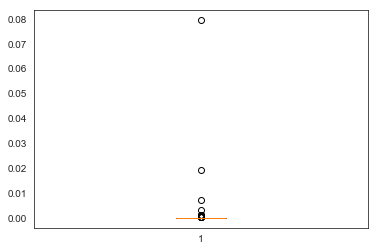

In [75]:
plt.boxplot(results[results["policy"] == "policy 0"]['Total Expected Number of Deaths'])

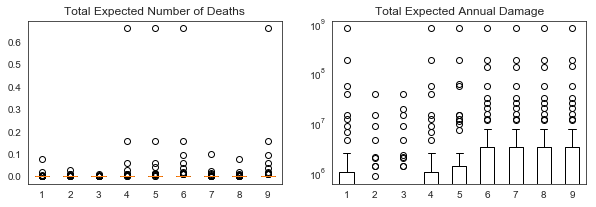

In [112]:
# Kwakkel, J.H., M. Haasnoot, & W.E. Walker. (2015). Developing Dynamic Adaptive Policy Pathways: A computer-assisted approach for developing adaptive strategies for a deeply uncertain world. Climatic Change. DOI: 10.1007/s10584-014-1210-4.


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
boxplots = {}

for ax, outcome in zip(axes, outcomes):
    for policy in policies:
        values = results[results['policy'] == policy][outcome]
        boxplots[policy] = values
        
    ax.boxplot([boxplots[policy] for policy in sorted(boxplots.keys())])
    
    if outcome == 'Total Expected Annual Damage':
        ax.set_yscale('log')
    ax.set_title(outcome)

plt.show()

In [117]:
test = results[results["policy"] == "policy 1"]['Total Expected Annual Damage']

In [115]:
# plt.boxplot(results[results["policy"] == "policy 1"]['Total Expected Annual Damage'])\

sp.stats.iqr(results[results["policy"] == "policy 1"]['Total Expected Annual Damage'])

0.0

In [120]:
np.percentile(test, 0.25)

0.0

In [119]:
np.percentile(test, 0.75)

0.0

In [118]:
np.percentile(test, 0.75) - np.percentile(test, 0.25)

0.0

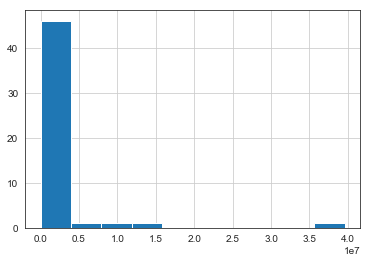

In [121]:
results[results["policy"] == "policy 1"]['Total Expected Annual Damage'].hist()

Caution when looking at the plots, because the legend is not fixed! 

In [ ]:
scatter_maker(results, "Expected Annual Damage")
scatter_maker(results, "Expected Number of Deaths")

In [ ]:
pairplot_maker(results, "A.2")

## Scenario Discovery

In [ ]:
aggregate_outcomes(results, "Expected Number of Deaths")
aggregate_outcomes(results, "Expected Annual Damage")

In [ ]:
boxplot_histogram_maker(results)

In [ ]:
x = results.iloc[:, :19] # Only take the uncertentainties 

y_deaths = results['Total Expected Number of Deaths'].values
y_deaths = y_deaths > np.percentile(y_deaths, 95)

In [ ]:
prim_alg = prim.Prim(x, y_deaths, threshold=0.55, peel_alpha=0.005)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

## Further investigation on specific locations

Check A.1 as well..

Further discovery of location A2 and time step 1 as the scatter plots and histograms showed that the policies are not robust yet. 

In [ ]:
y_deaths_A1 = results["A.1_Expected Number of Deaths 0"]
y_deaths_A1 = y_deaths_A1 > np.percentile(y_deaths_A1, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [ ]:
y_damages_A1 = results["A.1_Expected Annual Damage 0"]
y_damages_A1 = y_damages_A1 > np.percentile(y_damages_A1, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

## A.2

In [ ]:
# A.2_Expected Annual Damage 0
# A.2_Expected Number of Deaths 0

y_deaths_A2 = results["A.2_Expected Number of Deaths 0"]
y_deaths_A2 = y_deaths_A2 > np.percentile(y_deaths_A2, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A2, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [ ]:
y_damages_A2 = results["A.2_Expected Annual Damage 0"]
y_damages_A2 = y_damages_A2 > np.percentile(y_damages_A2, 90)

In [ ]:
prim_alg = prim.Prim(x, y_damages_A2, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
# PCA: same coverage

# x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
# x_categorical = x.select_dtypes(include=pd.CategoricalDtype)

# rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, y_damages_A2)

# rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)

# prim_obj = prim.Prim(rotated_x, y_damages_A2, threshold=0.1, peel_alpha=0.1)
# box1 = prim_obj.find_box()

# box1.show_tradeoff()
# plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()